%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

from geopy.distance import vincenty


import seaborn as sns
sns.set()

## Load Trip Data

In [2]:
print('Loading Trip Data...')

try:
    file_path_slug = '../../datasets/bayareabikeshare/*_trip_data.csv'

    # glob all files
    file_list = glob(file_path_slug)

    trip_import = pd.DataFrame()

    counter = 1
    chunks = []

    # load data from each file
    for file in file_list:

        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):

            # set chunk index column to 'Trip ID'
            chunk = chunk.set_index('Trip ID')

            # define Columns
            chunk.columns = ['Duration', 'Start Date', 'Start Station', 'Start Terminal', 'End Date', 
                             'End Station', 'End Terminal', 'Bike #', 'Subscriber Type', 'Zip Code']

            # append chunk to chunks list
            chunks.append(chunk)

        print('\tFinished file! (%d of %d)' % (counter, len(file_list)))
        counter += 1

    # concat chunks
    trip_import = pd.concat(chunks)

    print('Data Loaded Successfully!')

except:
    print('oops... something went wrong importing the data :(')

Loading Trip Data...
	Finished file! (1 of 4)
	Finished file! (2 of 4)
	Finished file! (3 of 4)
	Finished file! (4 of 4)
Data Loaded Successfully!


### Clean Trip Data

In [3]:
trip_data = trip_import.copy()
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983648 entries, 913465 to 198776
Data columns (total 10 columns):
Duration           983648 non-null int64
Start Date         983648 non-null object
Start Station      983648 non-null object
Start Terminal     983648 non-null int64
End Date           983648 non-null object
End Station        983648 non-null object
End Terminal       983648 non-null int64
Bike #             983648 non-null int64
Subscriber Type    983648 non-null object
Zip Code           976838 non-null object
dtypes: int64(4), object(6)
memory usage: 82.6+ MB


In [4]:
# our data set show duration in seconds, here are some handy conversions
second = 1
minute = second * 60
hour = minute * 60

# station ID numbers that are in San Francisco
sf_stations = [ 39,41,42,45,46,47,48,49,50,51,54,55,56,57,58,59,60,61,62,63,
                64,65,66,67,68,69,70,71,72,73,74,75,76,77,82,90,91]

In [5]:
# zipcodes are all over the place, only keep corrected 5 digit zipcodes, and replace all others with NaNs
def clean_zipcode(item):
    if len(item) != 5:

        # split on '-'
        try:
            result = item.split('-')[0]
        except:
            result = item

        # split on '.'
        try:
            result = item.split('.')[0]
        except:
            result = item
        
        # if len of item is less than 5, return 'NaN'
        if len(result) < 5:
            result = 'NaN'
        else:
            # if len result is greater than 5, take at most, first 5 digits
            result = result[:5]
    else:
        result = item
    
    # make sure result is all digits
    if result.isdigit():
        return result
    else:
        return 'NaN'

In [6]:
print('Trip Data Cleanup Started...')

# cleanup column names
print('\tcleaning column names')
new_cols = []
for col in trip_data.columns:
    new_cols.append(col.replace(' ', '_').lower())
trip_data.columns = new_cols

# extract columns we want to keep
print('\tsubsetting to useful columns')
important_cols = ['duration', 'start_date', 'start_terminal', 'end_date', 'end_terminal', 'bike_#', 'subscriber_type', 'zip_code']
trip_data = trip_data[important_cols]

# we are only looking at stations in San Francisco
sf_trips_data = trip_data[trip_data['start_terminal'].isin(sf_stations)]
sf_trips_data = sf_trips_data[sf_trips_data['end_terminal'].isin(sf_stations)]

trip_data = sf_trips_data.copy()

# create duration minutes column
print('\tcreating a duration_minutes column')
trip_data['duration_minutes'] = trip_data['duration'] / 60.0

# convert end and start dates to datetime objects
print('\tconverting end and start dates to datetime objects')
trip_data['start_date'] = pd.to_datetime(trip_data['start_date'], format="%m/%d/%Y %H:%M")
trip_data['end_date']   = pd.to_datetime(trip_data['end_date'],   format="%m/%d/%Y %H:%M")

# create a start and end hour trip column
print('\tcreating trip_date and trip_dow columns')
trip_data['trip_date']  = trip_data['start_date'].dt.date
trip_data['trip_dow']  = trip_data['start_date'].dt.weekday
trip_data['trip_day']  = trip_data['start_date'].dt.weekday_name

print('\tcreating start_hour and end_hour columns')
trip_data['start_hour'] = trip_data['start_date'].dt.hour
trip_data['end_hour']   = trip_data['end_date'].dt.hour

# convert and clean zipcodes
print('\tcleaning zipcodes')
trip_data['zip_code'] = trip_data['zip_code'].astype(str)
trip_data.zip_code = trip_data.zip_code.apply(clean_zipcode)
trip_data['zip_code'] = pd.to_numeric(trip_data['zip_code'], errors='coerce')

# clean up data types
print('cleaning up data types')

trip_data['duration']         = trip_data['duration'].astype('float')
# trip_data['start_date']       = trip_data['start_date'].astype('')
trip_data['start_terminal']   = trip_data['start_terminal'].astype('category')
# trip_data['end_date']         = trip_data['end_date'].astype('')
trip_data['end_terminal']     = trip_data['end_terminal'].astype('category')
trip_data['bike_#']           = trip_data['bike_#'].astype('int')
trip_data['subscriber_type']  = trip_data['subscriber_type'].astype('category')
trip_data['zip_code']         = trip_data['zip_code'].astype('str')
trip_data['duration_minutes'] = trip_data['duration_minutes'].astype('float')
# trip_data['trip_date']        = trip_data['trip_date'].astype('')
trip_data['trip_dow']         = trip_data['trip_dow'].astype('category')
trip_data['trip_day']         = trip_data['trip_day'].astype('category')
# trip_data['start_hour']       = trip_data['start_hour'].astype('')
# trip_data['end_hour']         = trip_data['end_hour'].astype('')


print('Trip Data Cleanup complete')
trip_clean = trip_data.copy()

Trip Data Cleanup Started...
	cleaning column names
	subsetting to useful columns
	creating a duration_minutes column
	converting end and start dates to datetime objects
	creating trip_date and trip_dow columns
	creating start_hour and end_hour columns
	cleaning zipcodes
cleaning up data types
Trip Data Cleanup complete


In [7]:
trip_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891200 entries, 913465 to 198776
Data columns (total 14 columns):
duration            891200 non-null float64
start_date          891200 non-null datetime64[ns]
start_terminal      891200 non-null category
end_date            891200 non-null datetime64[ns]
end_terminal        891200 non-null category
bike_#              891200 non-null int64
subscriber_type     891200 non-null category
zip_code            891200 non-null object
duration_minutes    891200 non-null float64
trip_date           891200 non-null object
trip_dow            891200 non-null category
trip_day            891200 non-null category
start_hour          891200 non-null int64
end_hour            891200 non-null int64
dtypes: category(5), datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 72.2+ MB


pruning data to trips no more than 60 minutes long...
	pruned data set 'trips' consists of 868208 entries


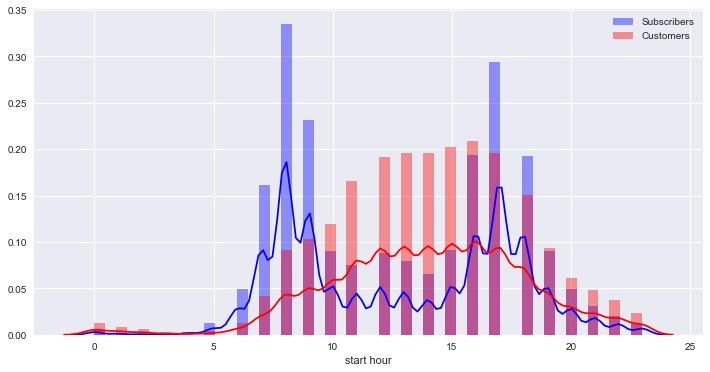

In [8]:
# prune data to exclude trips longer than 60 minutes
print('pruning data to trips no more than 60 minutes long...')
trips = trip_clean[trip_clean['duration_minutes'] <= 60].copy()

# Cleanup
trips.sort_index(inplace=True)
print('\tpruned data set \'trips\' consists of %i entries' % len(trips.index))

plt.subplots(figsize=(12,6))
ax = sns.distplot(trips[trips.subscriber_type == 'Subscriber'].start_date.dt.hour, color='b', label='Subscribers')
sns.distplot(trips[trips.subscriber_type == 'Customer'].start_date.dt.hour, color='r', label='Customers', ax=ax)
ax.set(xlabel='start hour')
plt.legend()
plt.show()

## Load Weather Data

In [9]:
print('Loading Weather Data...')

try:
    file_path_slug = '../../datasets/bayareabikeshare/*_weather_data.csv'

    # glob all files
    file_list = glob(file_path_slug)

    weather_import = pd.DataFrame()

    counter = 1
    chunks = []

    # load data from each file
    for file in file_list:

        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):

            chunk.columns = ['Date', 'Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF', 'Max_Dew_Point_F', 
                             'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 
                             'Max_Sea_Level_Pressure_In', 'Mean_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In', 
                             'Max_Visibility_Miles', 'Mean_Visibility_Miles', 'Min_Visibility_Miles', 
                             'Max_Wind_Speed_MPH', 'Mean_Wind_Speed_MPH', 'Max_Gust_Speed_MPH', 'Precipitation_In', 
                             'Cloud_Cover', 'Events', 'Wind_Dir_Degrees', 'zip']

            chunks.append(chunk)

        print('\tfinished file! (%d of %d)'% (counter, len(file_list)))
        counter += 1

    # concat chunks
    weather_import = pd.concat(chunks)

    print('Data Loaded Successfully!')
except:
    print('oops... something went wrong loading the data :()')

Loading Weather Data...
	finished file! (1 of 4)
	finished file! (2 of 4)
	finished file! (3 of 4)
	finished file! (4 of 4)
Data Loaded Successfully!


In [10]:
weather_data = weather_import.copy()
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5495 entries, 0 to 1824
Data columns (total 24 columns):
Date                          5495 non-null object
Max_Temperature_F             5491 non-null float64
Mean_Temperature_F            5491 non-null float64
Min_TemperatureF              5491 non-null float64
Max_Dew_Point_F               5441 non-null float64
MeanDew_Point_F               5441 non-null float64
Min_Dewpoint_F                5441 non-null float64
Max_Humidity                  5441 non-null float64
Mean_Humidity                 5441 non-null float64
Min_Humidity                  5441 non-null float64
Max_Sea_Level_Pressure_In     5494 non-null float64
Mean_Sea_Level_Pressure_In    5494 non-null float64
Min_Sea_Level_Pressure_In     5494 non-null float64
Max_Visibility_Miles          5473 non-null float64
Mean_Visibility_Miles         5473 non-null float64
Min_Visibility_Miles          5473 non-null float64
Max_Wind_Speed_MPH            5494 non-null float64
Mean_Wind_

### Clean Weather Data

In [11]:
print('Weather Data Cleanup Started...')

# cleanup column names
print('\tcleaning column names')
new_cols = []
for col in weather_data.columns:
    new_cols.append(col.replace(' ', '_').lower())
weather_data.columns = new_cols

# convert end and start dates to datetime objects
print('\tconverting dates to datetime objects')
weather_data['date'] = pd.to_datetime(weather_data['date'], format="%m/%d/%Y")

# extract columns we want to keep
print('\tsubsetting to useful columns')
important_cols = ['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperaturef',
                  'max_dew_point_f', 'meandew_point_f', 'min_dewpoint_f',
                  'max_wind_speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
                  'precipitation_in', 'cloud_cover', 'events', 'zip']
weather_data = weather_data[important_cols]

# correct min_temperaturef column name to min_temperature_f
# weather['min_temperaturef'].rename('min_temperature_f')
weather_data.rename(columns={'min_temperaturef': 'min_temperature_f'}, inplace=True)

# cleanup and set date as index
weather_data.set_index('date', inplace=True)
weather_data.sort_index(inplace=True)

# cleanup precipitation data to be all float values
weather_data['precipitation_in'] = pd.to_numeric(weather_data['precipitation_in'], errors='coerce')

# we only want San Francisco Weather information, zipcode 94107
weather_data = weather_data[weather_data.zip == 94107]

print('Weather Data Cleanup complete')
weather_clean = weather_data.copy()

Weather Data Cleanup Started...
	cleaning column names
	converting dates to datetime objects
	subsetting to useful columns
Weather Data Cleanup complete


## Load Station Data

In [12]:
print('Loading Station Data...')

try:
    file_path_slug = '../../datasets/bayareabikeshare/*_station_data.csv'

    # glob all files
    file_list = glob(file_path_slug)

    station_import = pd.DataFrame()

    counter = 1
    chunks = []

    # load data from each file
    for file in file_list:

        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):

            # set chunk index column to 'Trip ID'
#             chunk = chunk.set_index('Trip ID')

            # define Columns
            chunk.columns = ['station_id', 'name', 'lat', 'long', 'dockcount', 'landmark', 'installation']            
            
            # append chunk to chunks list
            chunks.append(chunk)

        print('\tFinished file! (%d of %d)' % (counter, len(file_list)))
        counter += 1

    # concat chunks
    station_import = pd.concat(chunks)

    print('Data Loaded Successfully!')

except:
    print('oops... something went wrong importing the data :(')

Loading Station Data...
	Finished file! (1 of 4)
	Finished file! (2 of 4)
	Finished file! (3 of 4)
	Finished file! (4 of 4)
Data Loaded Successfully!


### Clean Station Data

In [13]:
def label_zip(row):
    if row['landmark'] == 'San Francisco':
       return '94107'
    if row['landmark'] == 'Redwood City':
        return '94063'
    if row['landmark'] == 'Palo Alto':
        return '94301'
    if row['landmark'] == 'Mountain View':
        return '94041'
    if row['landmark'] == 'San Jose':
        return '95113'
    return '99999'

def make_lat_long(row):
    lat = row['lat']
    long = row['long']
    return (lat, long)

In [14]:
station_data = station_import.copy()

# remove dulplicates
print('remove dulplicates')
station_data.drop_duplicates(keep='first', inplace=True)
station_data.dropna(how='all', inplace=True)

# set datatype for each column
print('set datatype for each column')
station_data['station_id']   = station_data['station_id'].astype('int')
station_data['name']         = station_data['name'].astype('str')
station_data['lat']          = station_data['lat'].astype('float')
station_data['long']         = station_data['long'].astype('float')
station_data['landmark']     = station_data['landmark'].astype('category')

# add a zipcode column for later comparison with weather data
station_data['zip_code'] = station_data.apply(lambda row: label_zip (row),axis=1)
# station_data['zip_code'] = station_data['landmark'].astype('str')

# create lat,lon tuple column
station_data['lat_long'] = station_data.apply(lambda row: make_lat_long (row),axis=1)

# reindex to remove some extra duplicate
print('correcting index')
station_data.reset_index(inplace=True)
station_data.drop_duplicates(['station_id', 'installation'], keep='first', inplace=True)
station_data.set_index('station_id', inplace=True)
station_data.sort_index(inplace=True)
del station_data['index']

station_clean = station_data.copy()
print('Cleaning complete!')
station_clean.info()

remove dulplicates
set datatype for each column
correcting index
Cleaning complete!
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 2 to 91
Data columns (total 8 columns):
name            77 non-null object
lat             77 non-null float64
long            77 non-null float64
dockcount       77 non-null float64
landmark        77 non-null category
installation    77 non-null object
zip_code        77 non-null object
lat_long        77 non-null object
dtypes: category(1), float64(3), object(4)
memory usage: 5.1+ KB


## Append Route Distance column to Trips Data

In [15]:
def route_distance(row):
    
    # round trips are defaulting to zero km
    if row['start_terminal'] == row['end_terminal']:
        dist = 0.0
        return dist
    
#     print(row['start_terminal'], ' ', row['end_terminal'], ' ', row['trip_date'])
    # lookup start_station id coords
    start_gps = station_clean.loc[row['start_terminal']]['lat_long']

    # lookup end_station id coords
    end_gps = station_clean.loc[row['end_terminal']]['lat_long']

    
    '''
        this is sloppy, but some stations moved over time, we are just going to take the most recent 
        location coordinates, this is not an exact measurment by roadways, and we dont know the routes 
        that riders took anyway...
    '''
    

    
    if isinstance(start_gps, pd.core.series.Series):
        start_gps = start_gps.iloc[-1]
    if isinstance(end_gps, pd.core.series.Series):
        end_gps = end_gps.iloc[-1]

    try:
        dist = str(vincenty(start_gps, end_gps))
        dist = float(dist.split(' ')[0])
    except:
        dist = 'NaN'
            
    return dist
    

In [16]:
trips['distance_km'] = trips.apply(lambda row: route_distance (row),axis=1)
trips.head(3)

,duration,start_date,start_terminal,end_date,end_terminal,bike_#,subscriber_type,zip_code,duration_minutes,trip_date,trip_dow,trip_day,start_hour,end_hour,distance_km
Trip ID,,,,,,,,,,,,,,,
4069,174.0,2013-08-29 09:08:00,64,2013-08-29 09:11:00,64,288,Subscriber,94114.0,2.900000,2013-08-29,3,Thursday,9,9,0.000000
4073,1067.0,2013-08-29 09:24:00,66,2013-08-29 09:42:00,69,321,Subscriber,94703.0,17.783333,2013-08-29,3,Thursday,9,9,2.023518
4074,1131.0,2013-08-29 09:24:00,66,2013-08-29 09:43:00,69,317,Subscriber,94115.0,18.850000,2013-08-29,3,Thursday,9,9,2.023518


In [17]:
# histogram of ride distances

# plt.subplots(figsize=(12,6))
print(len(trips))

one_way_trips = trips[trips['distance_km'] > 0.0]
one_way_trips = one_way_trips[one_way_trips['duration_minutes'] <= 60.0]


print(len(one_way_trips))

868208
853131


In [18]:
print('one_way_trips[\'distance_km\'].mean()\t', one_way_trips['distance_km'].mean())
print('one_way_trips[\'distance_km\'].median()\t', one_way_trips['distance_km'].median())
print('one_way_trips[\'distance_km\'].min()\t', one_way_trips['distance_km'].min())
print('one_way_trips[\'distance_km\'].max()\t', one_way_trips['distance_km'].max())

one_way_trips['distance_km'].mean()	 1.40845840104
one_way_trips['distance_km'].median()	 1.3704034731570067
one_way_trips['distance_km'].min()	 0.076169502971
one_way_trips['distance_km'].max()	 3.7420551669


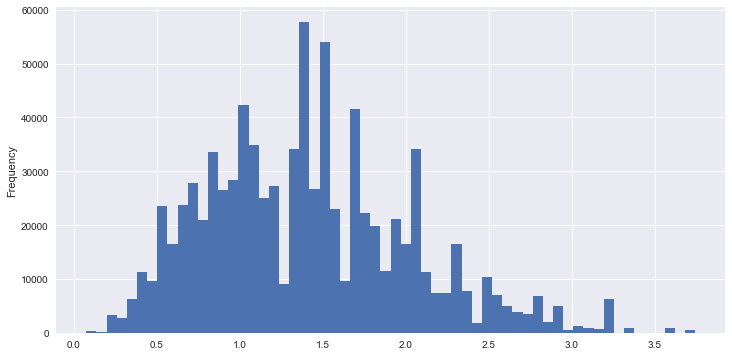

In [19]:
plt.subplots(figsize=(12,6))
one_way_trips['distance_km'].plot(kind='hist', bins=60)
plt.show()

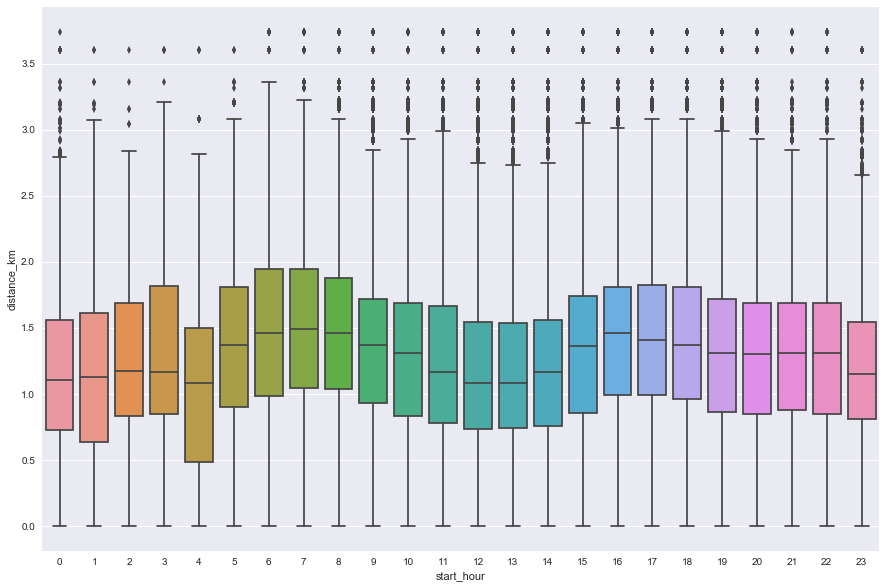

In [20]:
# trip_copy_select = trip_copy.head(100000)
plt.subplots(figsize=(15,10))
sns.boxplot(x='start_hour', y='distance_km', data=trips);
plt.show()

In [21]:
# trips_select_c = trips[trips['subscriber_type'] == 'Customer'].head(20000)
# sns.jointplot('start_terminal', 'distance_km', data=trips_select_c, kind='reg')
# plt.show()

# trips_select_s = trips[trips['subscriber_type'] == 'Subscriber'].head(20000)
# sns.jointplot('start_terminal', 'distance_km', data=trips_select_s, kind='reg')
# plt.show()

In [22]:
print('Customers:\t ', len(one_way_trips[one_way_trips['subscriber_type'] == 'Customer']))
print('Subscribers:\t', len(one_way_trips[one_way_trips['subscriber_type'] != 'Customer']))

Customers:	  90794
Subscribers:	 762337


In [23]:
# sns.jointplot('duration_minutes', 'distance_km', data=one_way_trips[one_way_trips['subscriber_type'] == 'Customer'], kind='reg')
# plt.legend()
# plt.show()

In [24]:
# sns.jointplot('duration_minutes', 'distance_km', data=one_way_trips[one_way_trips['subscriber_type'] == 'Subscriber'], kind='reg')
# plt.legend()
# plt.show()

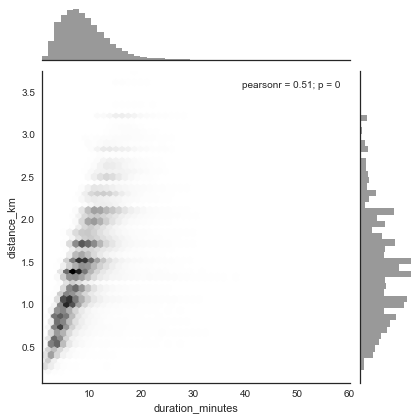

In [25]:
with sns.axes_style("white"):
    sns.jointplot(x=one_way_trips['duration_minutes'], y=one_way_trips['distance_km'], kind="hex", color="k");

# Analysis

## 1. Does Rain have an Impact on trip duration for Customers, or Subscribers?

In [26]:
# trips.info()

In [27]:
# split up rainy days and dry days
rainy_days = weather_clean[weather_clean['precipitation_in'] > 0.0].reset_index()
dry_days = weather_clean[weather_clean['precipitation_in'] == 0.0].reset_index()

# All trips
rainy_trips = trips[trips['start_date'].dt.date.isin(rainy_days['date'].dt.date)]
dry_trips = trips[trips['start_date'].dt.date.isin(dry_days['date'].dt.date)]

# Customer Trips
customer_rainy_trips = rainy_trips[rainy_trips.subscriber_type == 'Customer']
customer_dry_trips = dry_trips[dry_trips.subscriber_type == 'Customer']

# Subscriber Trips
subscriber_rainy_trips = rainy_trips[rainy_trips.subscriber_type == 'Subscriber']
subscriber_dry_trips = dry_trips[dry_trips.subscriber_type == 'Subscriber']

> A <b>Two Sample T Test</b> is appropriate for this problem as we are trying to see a difference between two sample means
- Mean ride duration on rainy days vs mean ride duration on dry days
>
>
> ##### All Trips
- $H$o : Mean Trip Duration on Rainy Days = Mean Trip Duration on Dry Days
- $H$a : Mean Trip Duration on Rainy Days ≠ Mean Trip Duration on Dry Days
>
> ##### Customer Trips
- $HC$o : Customer Mean Trip Duration on Rainy Days = Customer Mean Trip Duration on Dry Days
- $HC$a : Customer Mean Trip Duration on Rainy Days ≠ Customer Mean Trip Duration on Dry Days
>
> ##### Subscriber Trips
- $HS$o : Subscriber Mean Trip Duration on Rainy Days = Subscriber Mean Trip Duration on Dry Days
- $HS$a : Subscriber Mean Trip Duration on Rainy Days ≠ Subscriber Mean Trip Duration on Dry Days

### Results:

> ##### All Trips - Mean trip durations on rainy days are not equal to mean trip durations on dry days
- T Statistic <b>-21.3507</b> 
- P Value <b>4.1139e-101</b> which is well below the 0.05 threshhold thus we <b> reject</b> the $H$o

> ##### Customer Trips - Mean trip durations on rainy days are equal mean trip durations on dry days
- T Statistic <b>-0.7404</b> 
- P Value <b>0.4591</b> which is above the 0.05 threshhold thus we <b>can not reject</b> the $HC$o

> ##### Subscriber Trips - Mean trip durations on rainy days are not equal to mean trip durations on dry days
- T Statistic <b>-11.5109</b> 
- P Value <b>1.1706e-30</b> which is well below the 0.05 threshhold thus we <b>reject</b> the $HS$o

In [28]:
# All Trips
rainy_data = rainy_trips.duration_minutes
dry_data = dry_trips.duration_minutes

# Customer Trips Only
customer_rainy_data = customer_rainy_trips.duration_minutes
customer_dry_data = customer_dry_trips.duration_minutes

# Subscriber Trips Only
subscriber_rainy_data = subscriber_rainy_trips.duration_minutes
subscriber_dry_data = subscriber_dry_trips.duration_minutes

In [29]:
def calculate_stats(data1, data2):

    # means
    data1_mean = data1.mean()
    data2_mean = data2.mean()
    diff_mean = data1_mean - data2_mean
    print('Diff of means:\t\t', diff_mean)

    # calculate t statistic and p value with scipy
    t, p = stats.ttest_ind(data1, data2)
    print('T Test')
    print('\tt statistic:\t\t', t)
    print('\tp value:\t\t', p)
    print('')
    u, p2 = stats.mannwhitneyu(data1, data2)
    print('MannWhitneyU Test')
    print('\tu statistic:\t\t', u)
    print('\tp value:\t\t', p2)

In [30]:
print('All Trips')
calculate_stats(rainy_data, dry_data)
print()
print('-' * 40)
print('Customer Trips')
calculate_stats(customer_rainy_data, customer_dry_data)
print()
print('-' * 40)
print('Subscriber Trips')
calculate_stats(subscriber_rainy_data, subscriber_dry_data)

All Trips
Diff of means:		 -0.577173177778
T Test
	t statistic:		 -21.3506527393
	p value:		 4.11391933682e-101

MannWhitneyU Test
	u statistic:		 22078366690.0
	p value:		 3.57275576264e-85

----------------------------------------
Customer Trips
Diff of means:		 -0.121700791046
T Test
	t statistic:		 -0.740410046385
	p value:		 0.459053158314

MannWhitneyU Test
	u statistic:		 222135905.5
	p value:		 0.0381989762645

----------------------------------------
Subscriber Trips
Diff of means:		 -0.22798970971
T Test
	t statistic:		 -11.5108703941
	p value:		 1.17060149185e-30

MannWhitneyU Test
	u statistic:		 18233886701.5
	p value:		 6.56252812086e-26


In [31]:
# plt.subplots(figsize=(12,6))
# sns.swarmplot(x="trip_dow", y="start_hour", hue="start_hour", data=customer_rainy_trips);

In [32]:
customer_rainy_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5330 entries, 29608 to 1117763
Data columns (total 15 columns):
duration            5330 non-null float64
start_date          5330 non-null datetime64[ns]
start_terminal      5330 non-null category
end_date            5330 non-null datetime64[ns]
end_terminal        5330 non-null category
bike_#              5330 non-null int64
subscriber_type     5330 non-null category
zip_code            5330 non-null object
duration_minutes    5330 non-null float64
trip_date           5330 non-null object
trip_dow            5330 non-null category
trip_day            5330 non-null category
start_hour          5330 non-null int64
end_hour            5330 non-null int64
distance_km         5330 non-null float64
dtypes: category(5), datetime64[ns](2), float64(3), int64(3), object(2)
memory usage: 488.0+ KB


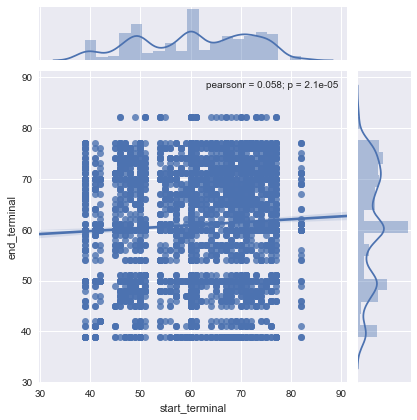

In [33]:
sns.jointplot('start_terminal', 'end_terminal', data=customer_rainy_trips, kind='reg')
plt.show()

In [34]:
# sns.jointplot('start_terminal', 'end_terminal', data=customer_rainy_trips[customer_rainy_trips['start_terminal'] == customer_rainy_trips['end_terminal']], kind='reg')
# plt.show()

# sns.jointplot('start_terminal', 'end_terminal', data=customer_rainy_trips[customer_rainy_trips['start_terminal'] != customer_rainy_trips['end_terminal']], kind='reg')
# plt.show()

In [35]:
# sns.jointplot('end_terminal', 'end_hour', data=customer_rainy_trips, kind='reg')
# plt.show()

## 2. Does Rain have an Impact on trip distance for Customers, or Subscribers?

> A <b>Two Sample T Test</b> is appropriate for this problem as we are trying to see a difference between two sample means
- Mean ride duration on rainy days vs mean ride duration on dry days
>
>
> ##### All Trips
- $H$o : Mean Trip Distance on Rainy Days = Mean Trip Distance on Dry Days
- $H$a : Mean Trip Distance on Rainy Days ≠ Mean Trip Distance on Dry Days
>
> ##### Customer Trips
- $HC$o : Customer Mean Trip Distance on Rainy Days = Customer Mean Trip Distance on Dry Days
- $HC$a : Customer Mean Trip Distance on Rainy Days ≠ Customer Mean Trip Distance on Dry Days
>
> ##### Subscriber Trips
- $HS$o : Subscriber Mean Trip Distance on Rainy Days = Subscriber Mean Trip Distance on Dry Days
- $HS$a : Subscriber Mean Trip Distance on Rainy Days ≠ Subscriber Mean Trip Distance on Dry Days

### Results:

> ##### All Trips - Mean trip durations on rainy days are not equal to mean trip durations on dry days
- T Statistic <b>-6.2193</b> 
- P Value <b>4.9967e-10</b> which is well below the 0.05 threshhold thus we <b> reject</b> the $H$o

> ##### Customer Trips - Mean trip durations on rainy days are equal mean trip durations on dry days
- T Statistic <b>0.08450</b> 
- P Value <b>0.9327</b> which is above the 0.05 threshhold thus we <b>can not reject</b> the $HC$o

> ##### Subscriber Trips - Mean trip durations on rainy days are not equal to mean trip durations on dry days
- T Statistic <b>-7.1311</b> 
- P Value <b>9.9694e-13</b> which is well below the 0.05 threshhold thus we <b>reject</b> the $HS$o


In [36]:
# All Trips
rainy_data = rainy_trips.distance_km
dry_data = dry_trips.distance_km

# Customer Trips Only
customer_rainy_data = customer_rainy_trips.distance_km
customer_dry_data = customer_dry_trips.distance_km

# Subscriber Trips Only
subscriber_rainy_data = subscriber_rainy_trips.distance_km
subscriber_dry_data = subscriber_dry_trips.distance_km

In [37]:
# All Trips
print('rainy_data:\t\t ', len(rainy_data))
print('dry_data:\t\t', len(dry_data))

# Customer Trips Only
print('customer_rainy_data:\t  ', len(customer_rainy_data))
print('customer_dry_data:\t', len(customer_dry_data))

# Subscriber Trips Only
print('subscriber_rainy_data:\t ', len(subscriber_rainy_data))
print('subscriber_dry_data:\t', len(subscriber_dry_data))

rainy_data:		  65475
dry_data:		 706956
customer_rainy_data:	   5330
customer_dry_data:	 84575
subscriber_rainy_data:	  60145
subscriber_dry_data:	 622381


In [38]:
print('All Trips')
calculate_stats(rainy_data, dry_data)
print()
print('-' * 40)
print('Customer Trips')
calculate_stats(customer_rainy_data, customer_dry_data)
print()
print('-' * 40)
print('Subscriber Trips')
calculate_stats(subscriber_rainy_data, subscriber_dry_data)

All Trips
Diff of means:		 -0.0162137669569
T Test
	t statistic:		 -6.21928747395
	p value:		 4.99671822552e-10

MannWhitneyU Test
	u statistic:		 22805009646.0
	p value:		 2.65160825377e-10

----------------------------------------
Customer Trips
Diff of means:		 0.000903294430492
T Test
	t statistic:		 0.0845018820488
	p value:		 0.93265759469

MannWhitneyU Test
	u statistic:		 225135945.0
	p value:		 0.444499471032

----------------------------------------
Subscriber Trips
Diff of means:		 -0.0189028615067
T Test
	t statistic:		 -7.13106392216
	p value:		 9.96941081693e-13

MannWhitneyU Test
	u statistic:		 18394266035.5
	p value:		 1.42728617883e-12


## Weekend vs weekday subscribers

In [39]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868208 entries, 4069 to 1338408
Data columns (total 15 columns):
duration            868208 non-null float64
start_date          868208 non-null datetime64[ns]
start_terminal      868208 non-null category
end_date            868208 non-null datetime64[ns]
end_terminal        868208 non-null category
bike_#              868208 non-null int64
subscriber_type     868208 non-null category
zip_code            868208 non-null object
duration_minutes    868208 non-null float64
trip_date           868208 non-null object
trip_dow            868208 non-null category
trip_day            868208 non-null category
start_hour          868208 non-null int64
end_hour            868208 non-null int64
distance_km         868208 non-null float64
dtypes: category(5), datetime64[ns](2), float64(3), int64(3), object(2)
memory usage: 117.0+ MB


In [40]:
trips.describe()

,duration,bike_#,duration_minutes,start_hour,end_hour,distance_km
count,868208.000000,868208.000000,868208.000000,868208.000000,868208.000000,868208.000000
mean,598.169864,438.976533,9.969498,13.002099,13.155172,1.384000
std,394.487439,138.036002,6.574791,4.554463,4.563102,0.637097
min,60.000000,9.000000,1.000000,0.000000,0.000000,0.000000
25%,354.000000,351.000000,5.900000,9.000000,9.000000,0.926630
50%,515.000000,447.000000,8.583333,13.000000,13.000000,1.368524
75%,725.000000,544.000000,12.083333,17.000000,17.000000,1.756103
max,3600.000000,878.000000,60.000000,23.000000,23.000000,3.742055


In [41]:
trips.head()

,duration,start_date,start_terminal,end_date,end_terminal,bike_#,subscriber_type,zip_code,duration_minutes,trip_date,trip_dow,trip_day,start_hour,end_hour,distance_km
Trip ID,,,,,,,,,,,,,,,
4069,174.0,2013-08-29 09:08:00,64,2013-08-29 09:11:00,64,288,Subscriber,94114.0,2.900000,2013-08-29,3,Thursday,9,9,0.000000
4073,1067.0,2013-08-29 09:24:00,66,2013-08-29 09:42:00,69,321,Subscriber,94703.0,17.783333,2013-08-29,3,Thursday,9,9,2.023518
4074,1131.0,2013-08-29 09:24:00,66,2013-08-29 09:43:00,69,317,Subscriber,94115.0,18.850000,2013-08-29,3,Thursday,9,9,2.023518
4075,1117.0,2013-08-29 09:24:00,66,2013-08-29 09:43:00,69,316,Subscriber,94122.0,18.616667,2013-08-29,3,Thursday,9,9,2.023518
4076,1118.0,2013-08-29 09:25:00,66,2013-08-29 09:43:00,69,322,Subscriber,94597.0,18.633333,2013-08-29,3,Thursday,9,9,2.023518


In [42]:
weekday_trips = trips[trips['start_date'].dt.weekday < 5]
weekend_trips = trips[trips['start_date'].dt.weekday >= 5]

In [43]:
# number of trips by weekday/weekend and subscriber type
weekday_customer_trips   = weekday_trips[weekday_trips.subscriber_type == 'Customer']
weekend_customer_trips   = weekend_trips[weekend_trips.subscriber_type == 'Customer']
weekday_subscriber_trips = weekday_trips[weekday_trips.subscriber_type != 'Customer']
weekend_subscriber_trips = weekend_trips[weekend_trips.subscriber_type != 'Customer']

# number of days with customer weekend trips
weekday_customer_trip_days =   len(pd.unique(weekday_customer_trips.trip_date))
weekend_customer_trip_days =   len(pd.unique(weekend_customer_trips.trip_date))
weekday_subscriber_trip_days = len(pd.unique(weekday_subscriber_trips.trip_date))
weekend_subscriber_trip_days = len(pd.unique(weekend_subscriber_trips.trip_date))

# trips per day for each group
weekday_customer_tpd   = len(weekday_customer_trips)   / weekday_customer_trip_days
weekend_customer_tpd   = len(weekend_customer_trips)   / weekend_customer_trip_days
weekday_subscriber_tpd = len(weekday_subscriber_trips) / weekday_subscriber_trip_days
weekend_subscriber_tpd = len(weekend_subscriber_trips) / weekend_subscriber_trip_days

customer_ratio   = weekday_customer_tpd / weekend_customer_tpd * 100.
subscriber_ratio = weekday_subscriber_tpd / weekend_subscriber_tpd  * 100.



print('-' * 80)
print('weekday_customer_trip_days:\t\t   ', weekday_customer_trip_days)
print('weekend_customer_trip_days:\t\t   ', weekend_customer_trip_days)
print('weekday_subscriber_trip_days:\t\t   ', weekday_subscriber_trip_days)
print('weekend_subscriber_trip_days:\t\t   ', weekend_subscriber_trip_days)
print('-' * 80)
print('Number of Weekday Customer Trips):\t ', len(weekday_customer_trips))
print('Number of Weekend Customer Trips):\t ', len(weekend_customer_trips))
print('Number of Weekday Subscriber Trips):\t', len(weekday_subscriber_trips))
print('Number of Weekend Subscriber Trips):\t ', len(weekend_subscriber_trips))
print('-' * 80)
print('weekday_customer Trips Per Day:\t\t    ', weekday_customer_tpd)
print('weekend_customer Trips Per Day:\t\t   ', weekend_customer_tpd)
print('weekday_subscriber Trips Per Day:\t   ', weekday_subscriber_tpd)
print('weekend_subscriber Trips Per Day:\t   ', weekend_subscriber_tpd)
print('-' * 80)
print('Customer Weekday/Weekend Ratio:\t\t   ', customer_ratio)
print('Subscriber Weekday/Weekend Ratio:\t  ', subscriber_ratio)
print('-' * 80)

--------------------------------------------------------------------------------
weekday_customer_trip_days:		    785
weekend_customer_trip_days:		    314
weekday_subscriber_trip_days:		    785
weekend_subscriber_trip_days:		    314
--------------------------------------------------------------------------------
Number of Weekday Customer Trips):	  60785
Number of Weekend Customer Trips):	  37746
Number of Weekday Subscriber Trips):	 719416
Number of Weekend Subscriber Trips):	  50261
--------------------------------------------------------------------------------
weekday_customer Trips Per Day:		     77.43312101910828
weekend_customer Trips Per Day:		    120.21019108280255
weekday_subscriber Trips Per Day:	    916.4535031847133
weekend_subscriber Trips Per Day:	    160.06687898089172
--------------------------------------------------------------------------------
Customer Weekday/Weekend Ratio:		    64.41477242621735
Subscriber Weekday/Weekend Ratio:	   572.5441196951911
-------------

In [44]:
weekday_customer_trips   = weekday_trips[weekday_trips.subscriber_type == 'Customer']
weekend_customer_trips   = weekend_trips[weekend_trips.subscriber_type == 'Customer']
weekday_subscriber_trips = weekday_trips[weekday_trips.subscriber_type != 'Customer']
weekend_subscriber_trips = weekend_trips[weekend_trips.subscriber_type != 'Customer']



In [45]:
# duration data
day_cust_dur  = weekday_customer_trips.duration_minutes
end_cust_dur  = weekend_customer_trips.duration_minutes
day_sub_dur  = weekday_subscriber_trips.duration_minutes
end_sub_dur  = weekend_subscriber_trips.duration_minutes

# distance data
day_cust_dist = weekday_customer_trips.distance_km
end_cust_dist = weekend_customer_trips.distance_km
day_sub_dist = weekday_subscriber_trips.distance_km
end_sub_dist = weekend_subscriber_trips.distance_km


In [46]:

print('-' * 40)
print('Customer Trip Duration')
calculate_stats(day_cust_dur, end_cust_dur)
print()
print('-' * 40)
print('Subscriber Trip Duration')
calculate_stats(day_sub_dur, end_sub_dur)
print()
print('-' * 40)

----------------------------------------
Customer Trip Duration
Diff of means:		 -2.65051051896
T Test
	t statistic:		 -34.956926157
	p value:		 4.3822035073e-266

MannWhitneyU Test
	u statistic:		 976404852.0
	p value:		 0.0

----------------------------------------
Subscriber Trip Duration
Diff of means:		 -0.727498989879
T Test
	t statistic:		 -34.0783234913
	p value:		 2.39556936544e-254

MannWhitneyU Test
	u statistic:		 17527297413.5
	p value:		 1.02403366764e-30

----------------------------------------


In [47]:
print('-' * 40)
print('Customer Trip Distance')
calculate_stats(day_cust_dist, end_cust_dist)
print()
print('-' * 40)
print('Subscriber Trip Distance')
calculate_stats(day_sub_dist, end_sub_dist)
print()
print('-' * 40)

----------------------------------------
Customer Trip Distance
Diff of means:		 0.0394471922525
T Test
	t statistic:		 7.96301179836
	p value:		 1.69676590779e-15

MannWhitneyU Test
	u statistic:		 1105469717.0
	p value:		 3.42836071845e-22

----------------------------------------
Subscriber Trip Distance
Diff of means:		 0.0853713340396
T Test
	t statistic:		 29.8553977778
	p value:		 9.67413222393e-196

MannWhitneyU Test
	u statistic:		 16312615371.5
	p value:		 6.33368844393e-295

----------------------------------------


In [48]:
customer_trips = trips[trips.subscriber_type == 'Customer']
subscriber_trips = trips[trips.subscriber_type == 'Subscriber']

In [49]:
_trips= stats.normaltest(trips.start_hour.sort_values())
print('_trips:\t\t', _trips)
_customer= stats.normaltest(customer_trips.start_hour.sort_values())
print('_customer:\t', _customer)
_subscriber= stats.normaltest(subscriber_trips.start_hour.sort_values())
print('_subscriber:\t', _subscriber)

_trips:		 NormaltestResult(statistic=448883.44258267729, pvalue=0.0)
_customer:	 NormaltestResult(statistic=2094.2028596330565, pvalue=0.0)
_subscriber:	 NormaltestResult(statistic=1033021.2210245988, pvalue=0.0)


In [50]:
# calculate_stats(rainy_data, dry_data)
stats.mannwhitneyu(rainy_data, dry_data)

MannwhitneyuResult(statistic=22805009646.0, pvalue=2.6516082537717947e-10)

In [51]:
stats.mannwhitneyu(dry_data, rainy_data)

MannwhitneyuResult(statistic=22805009646.0, pvalue=2.6516082537717947e-10)

In [52]:
stats.mannwhitneyu(customer_rainy_data, customer_dry_data)

MannwhitneyuResult(statistic=225135945.0, pvalue=0.44449947103202969)

In [53]:
stats.mannwhitneyu(subscriber_rainy_data, subscriber_dry_data)

MannwhitneyuResult(statistic=18394266035.5, pvalue=1.4272861788280371e-12)

In [54]:
am_trips = trips[trips.start_hour < 12]
pm_trips = trips[trips.start_hour >= 12]

In [55]:
am_start_terminal_trips = am_trips.groupby('start_terminal').duration.count()
pm_start_terminal_trips = pm_trips.groupby('start_terminal').duration.count()
calculate_stats(am_start_terminal_trips, pm_start_terminal_trips)

Diff of means:		 -3547.78378378
T Test
	t statistic:		 -1.82004068295
	p value:		 0.0729091948895

MannWhitneyU Test
	u statistic:		 396.0
	p value:		 0.000924370217673


In [56]:
am_end_terminal_trips = am_trips.groupby('end_terminal').duration.count()
pm_end_terminal_trips = pm_trips.groupby('end_terminal').duration.count()
calculate_stats(am_end_terminal_trips, pm_end_terminal_trips)

Diff of means:		 -3547.78378378
T Test
	t statistic:		 -1.55270394708
	p value:		 0.124878728166

MannWhitneyU Test
	u statistic:		 614.0
	p value:		 0.224597802244


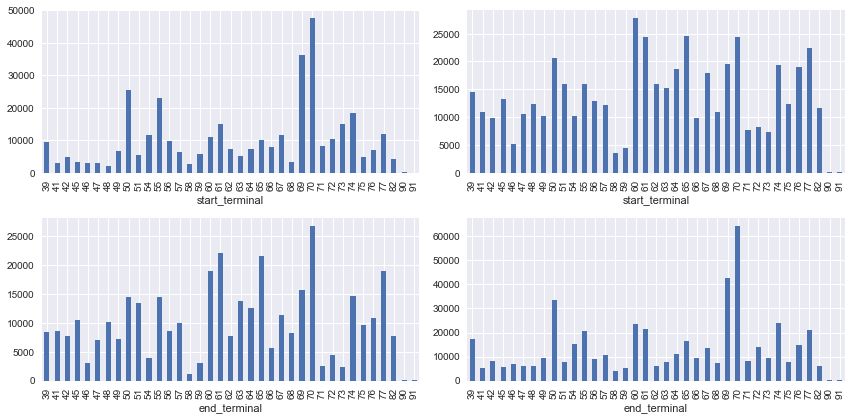

In [63]:
plt.subplot(2,2,1)
am_start_terminal_trips.plot(kind='bar', figsize=(12,6))

plt.subplot(2,2,2)
pm_start_terminal_trips.plot(kind='bar')

plt.subplot(2,2,3)
am_end_terminal_trips.plot(kind='bar')

plt.subplot(2,2,4)
pm_end_terminal_trips.plot(kind='bar')


plt.tight_layout()
plt.show()

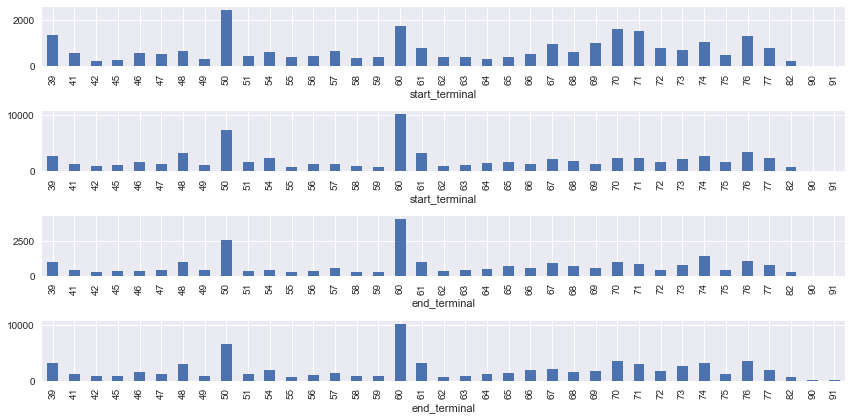

In [68]:

customer_am_start_terminal_trips = am_trips[am_trips.subscriber_type == 'Customer'].groupby('start_terminal').duration.count()
customer_am_end_terminal_trips = am_trips[am_trips.subscriber_type == 'Customer'].groupby('end_terminal').duration.count()

customer_pm_start_terminal_trips = pm_trips[pm_trips.subscriber_type == 'Customer'].groupby('start_terminal').duration.count()
customer_pm_end_terminal_trips = pm_trips[pm_trips.subscriber_type == 'Customer'].groupby('end_terminal').duration.count()

plt.subplot(4,1,1)
customer_am_start_terminal_trips.plot(kind='bar', figsize=(12,6))

plt.subplot(4,1,2)
customer_pm_start_terminal_trips.plot(kind='bar')

plt.subplot(4,1,3)
customer_am_end_terminal_trips.plot(kind='bar')

plt.subplot(4,1,4)
customer_pm_end_terminal_trips.plot(kind='bar')


plt.tight_layout()
plt.show()

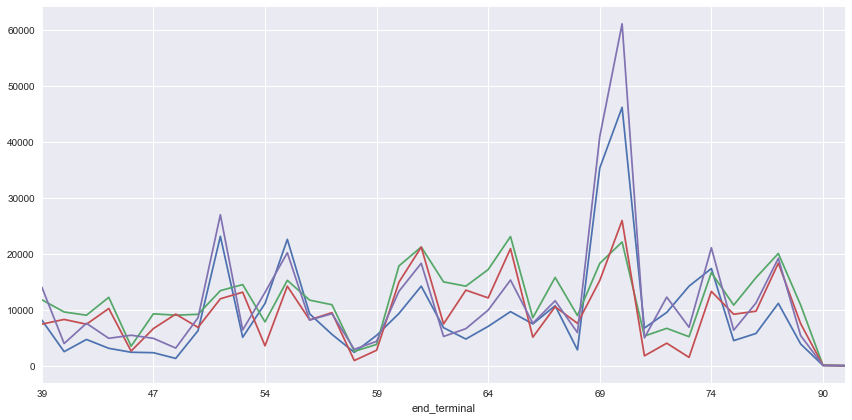

In [87]:
subscriber_am_start_terminal_trips = am_trips[am_trips.subscriber_type == 'Subscriber'].groupby('start_terminal').duration.count()
subscriber_am_end_terminal_trips = am_trips[am_trips.subscriber_type == 'Subscriber'].groupby('end_terminal').duration.count()

subscriber_pm_start_terminal_trips = pm_trips[pm_trips.subscriber_type == 'Subscriber'].groupby('start_terminal').duration.count()
subscriber_pm_end_terminal_trips = pm_trips[pm_trips.subscriber_type == 'Subscriber'].groupby('end_terminal').duration.count()


ax = subscriber_am_start_terminal_trips.plot(kind='line', figsize=(12,6))
subscriber_pm_start_terminal_trips.plot(kind='line', ax=ax)

subscriber_am_end_terminal_trips.plot(kind='line', ax=ax)
subscriber_pm_end_terminal_trips.plot(kind='line', ax=ax)

plt.tight_layout()
plt.show()

In [117]:
subscriber_am_start_terminal_trips = am_trips[am_trips.subscriber_type == 'Subscriber'].groupby('start_terminal').duration.count()
subscriber_am_end_terminal_trips = am_trips[am_trips.subscriber_type == 'Subscriber'].groupby('end_terminal').duration.count()

subscriber_pm_start_terminal_trips = pm_trips[pm_trips.subscriber_type == 'Subscriber'].groupby('start_terminal').duration.count()
subscriber_pm_end_terminal_trips = pm_trips[pm_trips.subscriber_type == 'Subscriber'].groupby('end_terminal').duration.count()

station_diff = pd.DataFrame()
station_diff['am_start_trips'] = subscriber_am_start_terminal_trips
station_diff['am_end_trips'] = subscriber_am_end_terminal_trips
station_diff['am_diff'] = subscriber_am_start_terminal_trips - subscriber_am_end_terminal_trips


station_diff['pm_start_trips'] = subscriber_pm_start_terminal_trips
station_diff['pm_end_trips'] = subscriber_pm_end_terminal_trips
station_diff['pm_diff'] = subscriber_pm_start_terminal_trips - subscriber_pm_end_terminal_trips

station_diff['removed_overnight'] = station_diff['am_diff'] - station_diff['pm_diff']

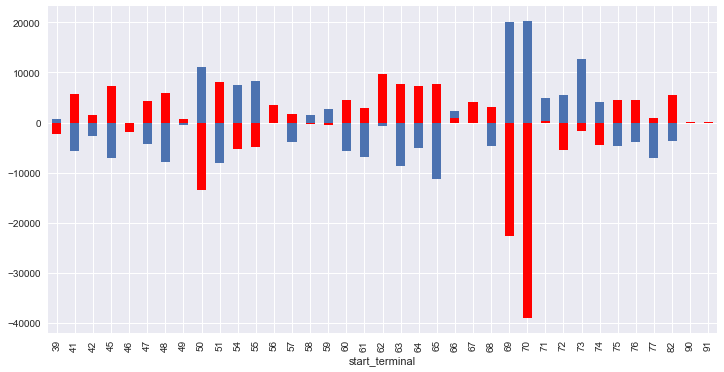

In [119]:
ax = station_diff.am_diff.plot(kind='bar', figsize=(12,6))
station_diff.pm_diff.plot(kind='bar', ax=ax, color='r')
plt.show()

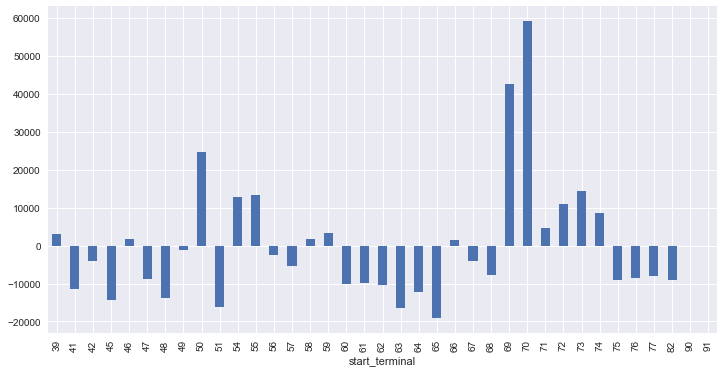

In [122]:
station_diff.removed_overnight.plot(kind='bar', figsize=(12,6))
plt.show()

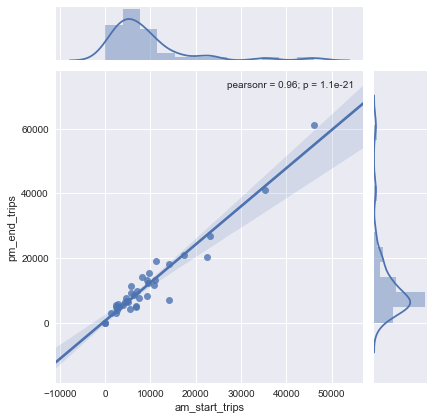

In [129]:
sns.jointplot(x='am_start_trips', y='pm_end_trips', data=station_diff, kind='reg')
plt.show()

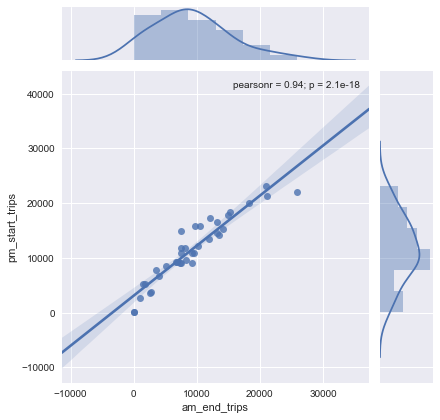

In [130]:
sns.jointplot(x='am_end_trips', y='pm_start_trips', data=station_diff, kind='reg')
plt.show()

In [161]:
hourly_stations = pd.DataFrame()
hourly_stations_diff = pd.DataFrame()

for i in range(0, 24):
    _trips = trips[trips.start_hour == i]
    _start_terminal = _trips.groupby('start_terminal').duration.count()
    _end_terminal = _trips.groupby('end_terminal').duration.count()
    
    start_string = 'hour%s_end' % str(i)
    end_string = 'hour%s_start' % str(i)
    diff_string = 'hour%s' % str(i)
    hourly_stations[end_string] = _end_terminal
    hourly_stations[start_string] = _start_terminal
    hourly_stations_diff[diff_string] = _start_terminal - _end_terminal


In [162]:
hourly_stations.head(3)

,hour0_start,hour0_end,hour1_start,hour1_end,hour2_start,hour2_end,hour3_start,hour3_end,hour4_start,hour4_end,...,hour19_start,hour19_end,hour20_start,hour20_end,hour21_start,hour21_end,hour22_start,hour22_end,hour23_start,hour23_end
end_terminal,,,,,,,,,,,,,,,,,,,,,
39,132,143,72,118,47,54,20,19,20,26,...,1557,1207,785,924,611,646,386,456,244,317
41,28,60,23,34,17,22,17,13,26,5,...,324,674,190,339,190,212,84,166,46,125
42,46,61,14,22,7,8,6,4,2,22,...,684,565,370,344,233,188,183,158,98,81


In [171]:
hourly_stations_diff.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 37 entries, 39 to 91
Data columns (total 24 columns):
hour0     37 non-null int64
hour1     37 non-null int64
hour2     37 non-null int64
hour3     37 non-null int64
hour4     37 non-null int64
hour5     37 non-null int64
hour6     37 non-null int64
hour7     37 non-null int64
hour8     37 non-null int64
hour9     37 non-null int64
hour10    37 non-null int64
hour11    37 non-null int64
hour12    37 non-null int64
hour13    37 non-null int64
hour14    37 non-null int64
hour15    37 non-null int64
hour16    37 non-null int64
hour17    37 non-null int64
hour18    37 non-null int64
hour19    37 non-null int64
hour20    37 non-null int64
hour21    37 non-null int64
hour22    37 non-null int64
hour23    37 non-null int64
dtypes: int64(24)
memory usage: 8.5 KB


In [163]:
hourly_stations_diff.head(3)

,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,hour9,...,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
start_terminal,,,,,,,,,,,,,,,,,,,,,
39,11,46,7,-1,6,120,407,-126,108,321,...,-156,-281,-747,-892,-697,-350,139,35,70,73
41,32,11,5,-4,-21,17,-117,-1826,-2592,-884,...,174,496,1860,1570,915,350,149,22,82,79
42,15,8,1,-2,20,-70,363,-910,-1932,-18,...,60,133,659,781,245,-119,-26,-45,-25,-17
